In [1]:
import shap
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from shap import Explanation
from rdkit import Chem
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_id = 1 #1: Buchwald-Hartwig, 2: Suzuki-Miyaura

In [3]:
if data_id == 1:
    from util import list_smiles_1 as list_smiles
    
elif data_id == 2:
    from util import list_smiles_2 as list_smiles

smi_dict = {'None': '[None]'}
for k, v in list_smiles.items():
    v2 = Chem.MolToSmiles(Chem.MolFromSmiles(v))
    if v2 in smi_dict:
        continue
    else:
        smi_dict[v2] = k

In [4]:
if data_id == 1:
    col_list= ['aryl_halide','ligand','base','additive']
    feature_names = col_list + ['mean_yield'] + ['%s_score'%col for col in col_list] + ['pred_yield', 'yield']
    
    data = [pd.read_csv('./result/output_1_%d_2767.csv'%iter, header = None, names = feature_names, dtype=str).sort_values(by = ['yield'] + col_list).reset_index(drop=True).fillna('None') for iter in range(10)]

elif data_id == 2:
    col_list = ['reactant_1','reactant_2','ligand','base','solvent']
    feature_names = col_list + ['mean_yield'] + ['%s_score'%col for col in col_list] + ['pred_yield', 'yield']
    
    data = [pd.read_csv('./result/output_2_%d_4032.csv'%iter, header = None, names = feature_names).sort_values(by = ['yield'] + col_list).reset_index(drop=True).fillna('None') for iter in range(10)]

data = pd.concat([data[0][col_list],
                  sum([data[iter][['mean_yield'] + ['%s_score'%col for col in col_list] + ['pred_yield', 'yield']].astype(float) for iter in range(10)])/10
                 ], axis = 1)

for col in col_list:
    data[col] = data[col].map(smi_dict)

base_score = np.unique(data['mean_yield'].unique()[0])
assert len(base_score) == 1

82.63337506999996
0.31337871504000026


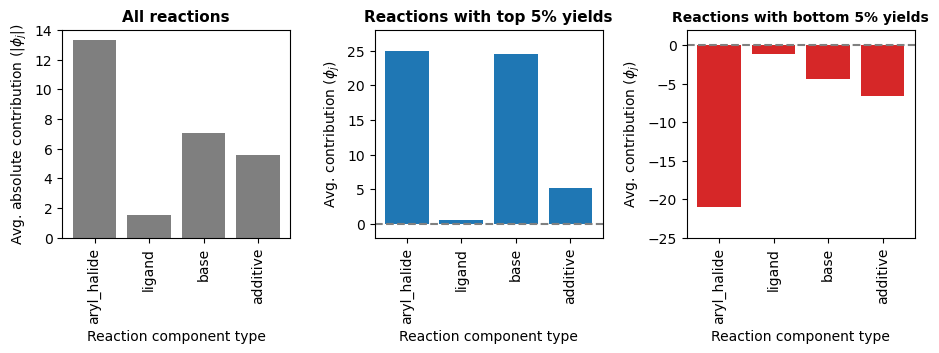

<Figure size 640x480 with 0 Axes>

In [5]:
fig = plt.figure(figsize=(11,2.7))

ax = plt.subplot(1, 3, 1)
plt.bar(col_list, [data['%s_score' % col].abs().mean() for col in col_list], color='tab:gray')
plt.xlabel('Reaction component type')
plt.ylabel('Avg. absolute contribution ($|\phi_j|$)')
plt.ylim(0, 14)
plt.title('All reactions', fontsize=11, fontweight='bold')
plt.xticks(rotation=90)

ax = plt.subplot(1, 3, 2)
threshold = data['pred_yield'].quantile(0.95)
print(threshold)
plt.axhline(y=0, color='gray', linestyle='--')
plt.bar(col_list, [data[data['pred_yield']>=threshold]['%s_score' % col].mean() for col in col_list], color='tab:blue')
plt.xlabel('Reaction component type')
plt.ylabel('Avg. contribution ($\phi_j$)')
plt.ylim(-2, 28)
plt.title('Reactions with top 5% yields', fontsize=11, fontweight='bold')
plt.xticks(rotation=90)

ax = plt.subplot(1, 3, 3)
threshold = data['pred_yield'].quantile(0.05)
print(threshold)
plt.axhline(y=0, color='gray', linestyle='--')
plt.bar(col_list, [data[data['pred_yield']<=threshold]['%s_score' % col].mean() for col in col_list], color='tab:red')
plt.xlabel('Reaction component type')
plt.ylabel('Avg. contribution ($\phi_j$)')
plt.ylim(-25, 2)
plt.title('Reactions with bottom 5% yields', fontsize=10, fontweight='bold')
plt.xticks(rotation=90)

plt.subplots_adjust(wspace=0.37)
plt.show()

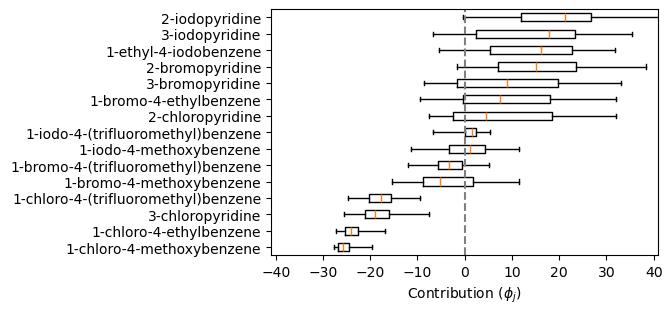

<Figure size 640x480 with 0 Axes>

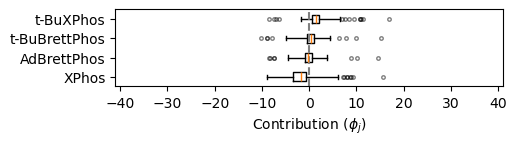

<Figure size 640x480 with 0 Axes>

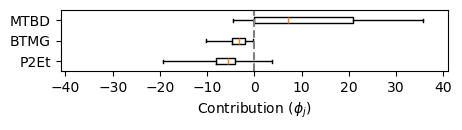

<Figure size 640x480 with 0 Axes>

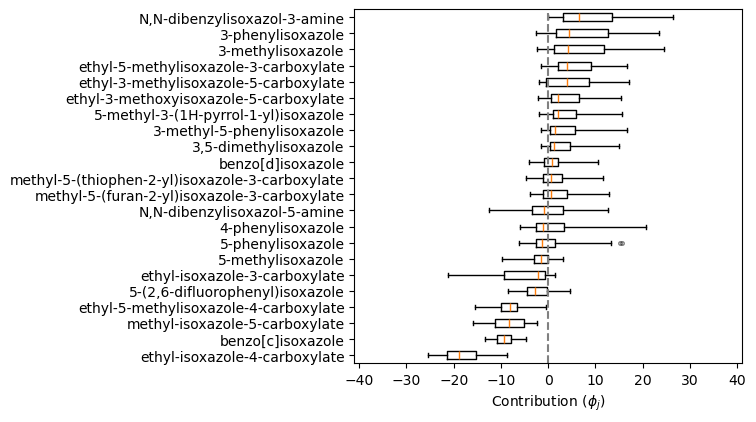

<Figure size 640x480 with 0 Axes>

In [6]:
flierprops = dict(marker='.', markersize=5, markeredgecolor='k', alpha=0.5)

for col in col_list:

    v = data.groupby(col)['%s_score' % col].median().sort_values()[::-1]
    v = list(v.keys())[::-1]

    plt.figure(figsize = (5,0.2+0.2*len(v)))
    
    plt.boxplot([data.loc[data[col]==x,'%s_score' % col] for x in v], whis=3, flierprops=flierprops, vert=False)
    plt.suptitle('')
    plt.xlabel('Contribution ($\phi_j$)')
    plt.yticks(range(1, len(v)+1), v, rotation=0)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.xlim(-41, 41)

    plt.show()

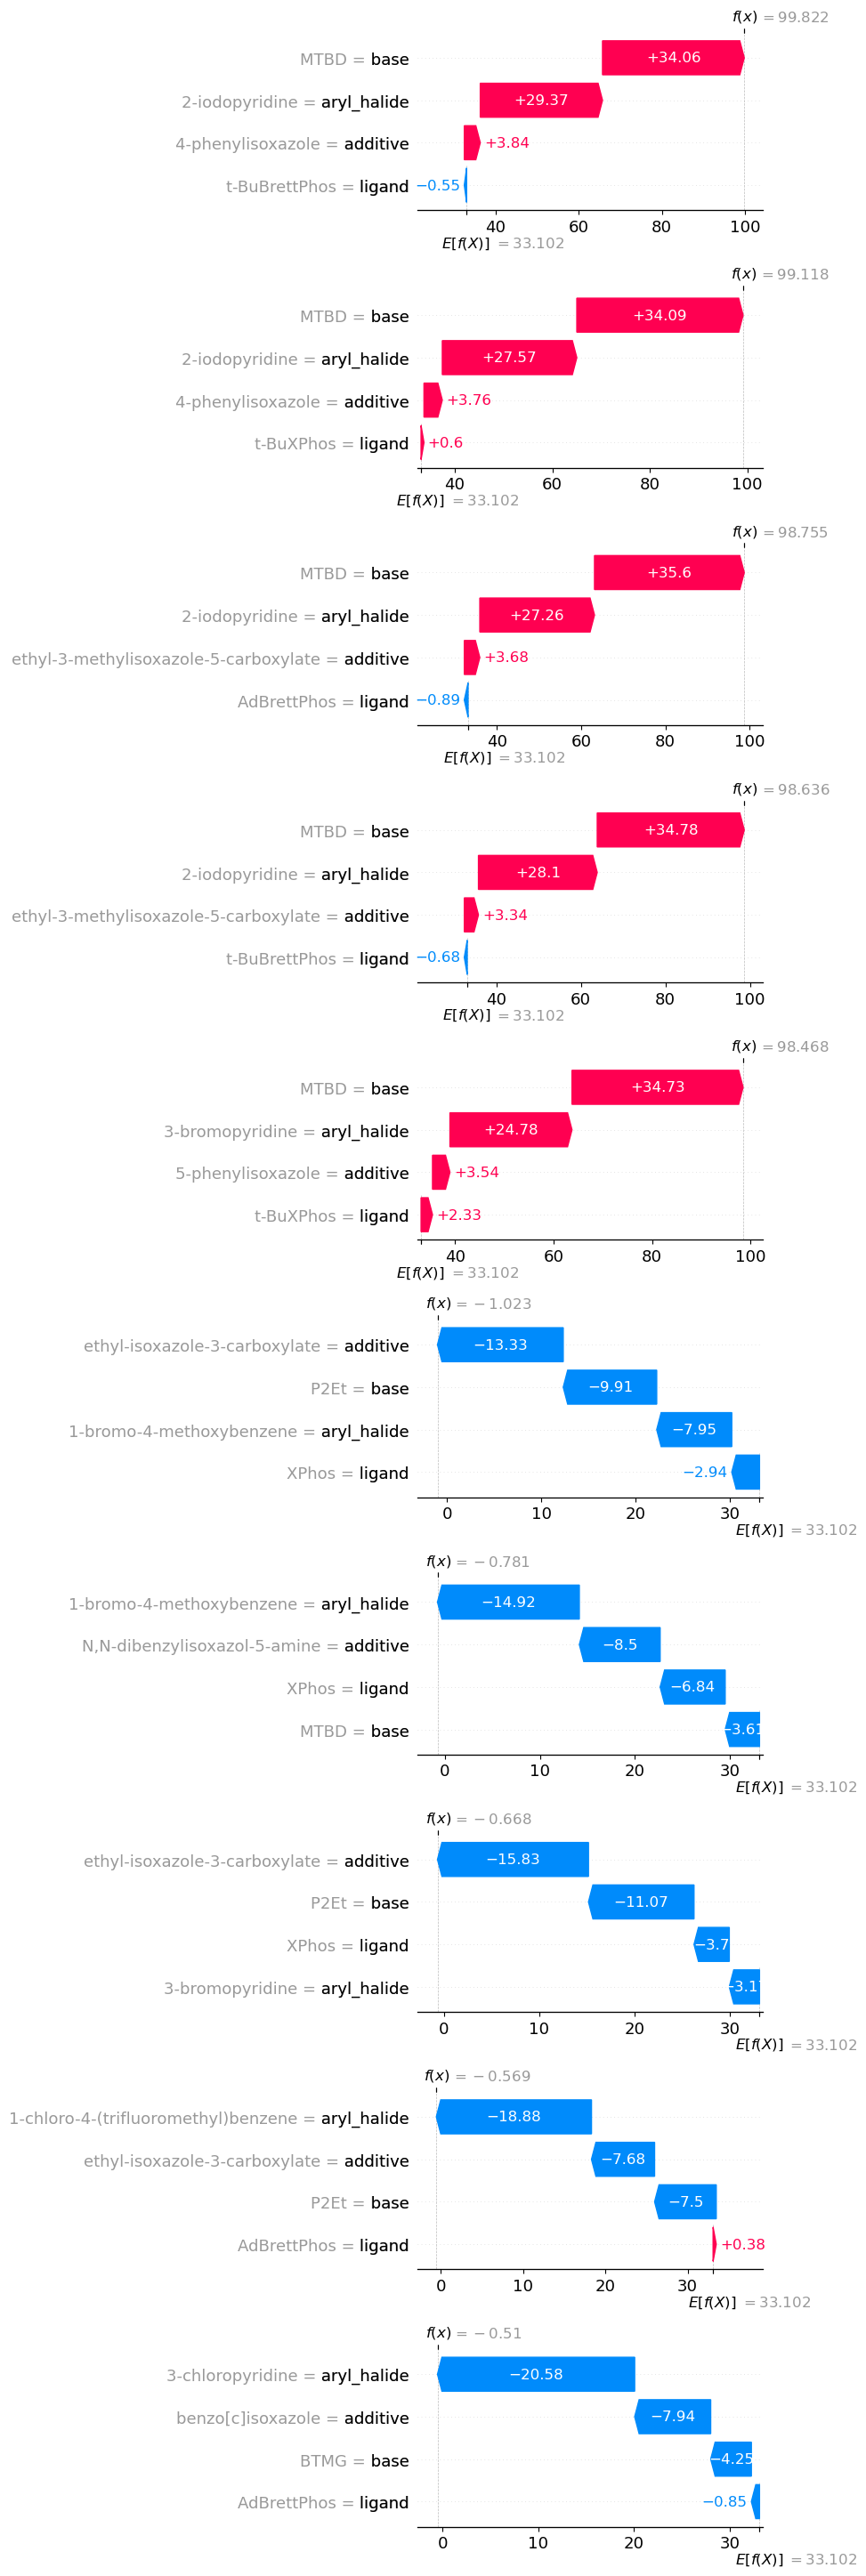

<Figure size 640x480 with 0 Axes>

In [7]:
fig = plt.figure(figsize=(12,30))

idx_list = np.argsort(-data['pred_yield'])[:5]
for i, idx in enumerate(idx_list):
    ax = plt.subplot(10, 1, i+1)

    feature_values = list(data.iloc[idx][:len(col_list)])
    feature_scores = list(data.iloc[idx][len(col_list)+1:-2])
    
    exp = Explanation(np.array([feature_scores]), 
                      np.array([base_score]), 
                      data=[feature_values], 
                      feature_names=col_list)#

    shap.plots.waterfall(exp[0], show=False)


idx_list = np.argsort(data['pred_yield'])[:5]
for i, idx in enumerate(idx_list):
    ax = plt.subplot(10, 1, i+6)

    feature_values = list(data.iloc[idx][:len(col_list)])
    feature_scores = list(data.iloc[idx][len(col_list)+1:-2])
    
    exp = Explanation(np.array([feature_scores]), 
                      np.array([base_score]), 
                      data=[feature_values], 
                      feature_names=col_list)

    shap.plots.waterfall(exp[0], show=False)

if data_id == 2: 
    fig.set_size_inches(5, 32*1.3)
    plt.subplots_adjust(hspace=0.35)
elif data_id == 1:
    fig.set_size_inches(5, 28*1.3)
    plt.subplots_adjust(hspace=0.45)

plt.show()